### -----------------------------------------------------------------------------------------------------------------------------------------------------

# CSC 792 - Applied Reinforcement Learning
## Professor: Dr. Rodrigue Rizk

### Submitted by: Prajwol Tiwari [101144638]

### -----------------------------------------------------------------------------------------------------------------------------------------------------

### We need to download SUMO inorder to train the model.


### Importing all necessary libraries

In [1]:
import os
import sys
import time
import optparse
import random
import numpy as np
import torch
from sumolib import checkBinary  
import traci 
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

### Defining three functions:
#### 1) tally_vehicles_in_lanes: to count the number of vehciles in each lane in the network used for simulation
#### 2) tally_vehicles_in_lanes: to calculate the total waiting time of vehicles in all lanes
#### 3) configure_trafficlight_phase: to configure the traffic light phase at a junction with a certain duration and configuration

In [2]:
def tally_vehicles_in_lanes(road_lanes):
    lane_vehicle_count = {}
    for lane_id in road_lanes:
        lane_vehicle_count[lane_id] = sum(
            1 for veh_id in traci.lane.getLastStepVehicleIDs(lane_id) 
            #traci.lane.getLastStepVehicleIDs is a method from TraCI API.
            
            if traci.vehicle.getLanePosition(veh_id) > 10
        )
    return lane_vehicle_count
    
    """
    this method first takes a list of all lane ids as the argument in order to calculate the total number of vehicles
    present in each lane provided by the getLastStepVehicleIDs.
    It then checks if the vehciles which are present in the network are within the certain lenght of the lane or not 
    (in this case 10 meters of the lane). The purpose of this check is likely to exclude vehicles that are still in the 
    process of entering the lane and have not fully entered the lane yet. 
    """

In [3]:
def compute_total_waiting_time(road_lanes):
    return sum(traci.lane.getWaitingTime(single_lane) for single_lane in road_lanes)

    """
    compute_total_waiting_time takes a list of lane ids (road_lanes) as input and returns the sum of 
    waiting times for each lane.
    """

In [4]:
def configure_trafficlight_phase(junction_id, phase_duration, phase_config):
    traci.trafficlight.setRedYellowGreenState(junction_id, phase_config)
    traci.trafficlight.setPhaseDuration(junction_id, phase_duration)
    
    """
    -> This function is used to configue the trafffic light at a particular junction for a specific amount of time.
    -> setRedYellowGreenState(junction_id, phase_config)--> takes two arguments as we can see. It gets the id for each 
       intersection and then set the traffic phase based on "phase_config"
    -> setPhaseDuration(junction_id, phase_duration)--> it also takes two arguments which also take id of intersection
        and set the traffic phase for a certain amount of time.
    """

### Defining Deep Neural Network model using Pytorch

In [5]:
class NeuralNetwork(nn.Module): ## inheriting from nn.Module class provided by Pytorch
    def __init__(self, learning_rate, input_dimensions, layer1_dimensions, layer2_dimensions, action_count):
        super(NeuralNetwork, self).__init__()
        
        self.learning_rate = learning_rate
        
        self.input_dimensions = input_dimensions 
        #defining the number of input features for the network
        
        self.layer1_dimensions = layer1_dimensions
        #defining the number of nodes in the first hideen layer
        
        self.layer2_dimensions = layer2_dimensions 
        #definign the nimber of nodes in the second hidden layer
        
        self.action_count = action_count 
        #defining the number of possible actions the network can output

        self.layer1 = nn.Linear(self.input_dimensions, self.layer1_dimensions)
        #creating the first linear transformation layer
        
        self.layer2 = nn.Linear(self.layer1_dimensions, self.layer2_dimensions)
        #creating the second linear transformation layer
        
        self.output_layer = nn.Linear(self.layer2_dimensions, self.action_count)
        #creating the third linear transformation layer which is also the final and output layer

        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        # we are using Adam Optimizer in our program since it update the learning rate for each parameter 
        # based on the history of gradient and has good convergenbce speed
        
        self.loss_function = nn.MSELoss()
        # We are using Mean Squared Error (MSE) loss function for our model. Computing the difference between 
        # the predicted output of the network and the target model
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        

    def forward(self, input_state):
        #after already defining the input layer, hidden layers and output layer, now defining the output function for 
        # each layer defined earlier
        
        layer1_output = F.relu(self.layer1(input_state))
        # layer1 output will activate the non-linear activation funciton which is ReLU in our case and  it will be passed
        # to another layer for processing which will again be converted to Linear tarnsformation
        
        layer2_output = F.relu(self.layer2(layer1_output))
        # same like in layer1 ouput, it will again be converted to non-linear transformation and then passed to another 
        # layer for further processing
        
        action_values = self.output_layer(layer2_output)
        # in this case, we won'tbe activating the non-linear transformation because this is the output layer.
        return action_values


### Defining Agent for our reinforcement learning model

In [6]:
""" Creating RLAgent class which represents a reinforcement learning agent that interacts with the environment, stores 
and learns from experience in memory, and selects actions based on a trained neural network.

"""

class RLAgent:
    # Constructor method to initialize the RLAgent class with necessary parameters
    def __init__(
        self,
        discount_factor,
        exploration_rate,
        learning_rate,
        input_dimensions,
        layer1_dimensions,
        layer2_dimensions,
        batch_size,
        action_count,
        junctions,
        max_memory_size=100000,
        
        # max_memory_size is set to 100000, 
        # which means that each junction's memory buffer can store up to 99999 experience tuples.
        
        exploration_rate_decay=0.0005,
        # exploration_rate_decay is set to 0.0005, which means that the exploration rate will 
        # be reduced by a factor of 0.0005 after each iteration
        
        exploration_rate_end=0.05,
    ):
        
        
        
        # Initialize the RLAgent instance variables with the given parameters
        
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.input_dimensions = input_dimensions
        self.layer1_dimensions = layer1_dimensions
        self.layer2_dimensions = layer2_dimensions
        self.action_count = action_count
        
        
        
        # Create a list of actions based on the action count
        self.action_space = [i for i in range(action_count)]
        
        # Set the junctions
        self.junctions = junctions
        
        # Set the maximum memory size for the RLAgent
        self.max_memory = max_memory_size
        
        # Set the exploration rate decay
        self.exploration_rate_decay = exploration_rate_decay
        
        # Set the end value for the exploration rate
        self.exploration_rate_end = exploration_rate_end
        
        # Initialize memory counter and iteration counter
        self.memory_counter = 0
        self.iteration_counter = 0
        
        
        # Set the target replace
        self.target_replace = 100
        
        # Create a neural network instance to evaluate the action values
        self.eval_net = NeuralNetwork(
            self.learning_rate, self.input_dimensions, self.layer1_dimensions, self.layer2_dimensions, self.action_count
        )
        
        # Create a memory dictionary for each junction with state memory, new state memory, reward memory, 
        # action memory, terminal memory, memory counter and iteration counter
        self.memory = dict()
        for junction in junctions:
            self.memory[junction] = {
                "state_memory": np.zeros(
                    (self.max_memory, self.input_dimensions), dtype=np.float32
                ),
                "new_state_memory": np.zeros(
                    (self.max_memory, self.input_dimensions), dtype=np.float32
                ),
                "reward_memory": np.zeros(self.max_memory, dtype=np.float32),
                "action_memory": np.zeros(self.max_memory, dtype=np.int32),
                "terminal_memory": np.zeros(self.max_memory, dtype=bool),
                "memory_counter": 0,
                "iteration_counter": 0,
            }
            
    # Store the state, new state, action, reward, done and junction information in memory
    def store_transition(self, state, new_state, action, reward, done, junction):
        
        index = self.memory[junction]["memory_counter"] % self.max_memory
        # it is important in experience replay to keep the memory store updated. Since, our memory tuple capactiy is of 
        # size 100000, we need to keep the memory updated on regular basis. Thus, we are checking the index of current
        # memory in memory store and using % to find the index. 
        # How does that work?
        # The % operator is the modulo operator, which returns the remainder of a division operation. 
        # In this case, it is used to calculate the index at which the new experience tuple should be stored in the 
        # memory buffer.
        
        self.memory[junction]["state_memory"][index] = state
        self.memory[junction]["new_state_memory"][index] = new_state
        self.memory[junction]['reward_memory'][index] = reward
        self.memory[junction]['terminal_memory'][index] = done
        self.memory[junction]["action_memory"][index] = action
        self.memory[junction]["memory_counter"] += 1

        
        
    # Select an action based on the current observation and exploration rate    
    def select_action(self, observation):
        state = torch.tensor([observation], dtype=torch.float).to(self.eval_net.device)
        # passing the current state of the environment as input to the state variable which will create the multi-
        # dimensional array and then move it to neural network model in the same work environment.
        
        
        # Decide whether to explore or exploit based on the exploration rate
        if np.random.random() > self.exploration_rate:
            actions = self.eval_net.forward(state)
            action = torch.argmax(actions).item()
            
            
        # Explore by selecting a random action from the action space    
        else:
            action = np.random.choice(self.action_space)
        return action

    
    
    # Reset memory for the specified junctions
    def reset(self, junction_numbers):
        for junction_number in junction_numbers:
            self.memory[junction_number]['memory_counter'] = 0
            
            """
            Since we are using this agent in an environment where there are multiple episodes or trials, we have to 
            to reset the memory counters for specific junctions at the beginning of each new episode or trial. 
            This is done to ensure that the agent starts with a clean slate in terms of memory for the new episode or 
            trial.
            
            """

            
    # Save the trained model to a file        
    def save(self, model_name):
        torch.save(self.eval_net.state_dict(), f'trained_model/{model_name}.bin')
        
        """
        We are saving the model for further uses later like in case of demonstration of simulation. 
        We can use the same model to see how our model performed by loading it in SUMO simulator.
        Moreover, we can also use it for other things like checkpointing, model evaluation, transfer learning, sharing
            and collaboration and so on.
        """

        
    
    # Update the evaluation network with the stored transitions    
    """
    After the forward feed is done in our neural network mode, we will then have to look at our memory and make some
    improvements in our neural network parameters. We take the current intersection and then based on that intersection's 
    memory.
    
    """
    def learn(self, junction):
        
        """
         This method updates the agent's neural network based on the agent's experiences stored in memory. 
         It calculates the loss between the Q-values estimated by the neural network and the target Q-values, 
         then uses backpropagation and an optimizer to update the neural network parameters. The method also updates 
         the agent's iteration counter and exploration rate, allowing the agent to balance exploration and exploitation 
         during the learning process.
        """
        
        # Zero the gradient of the optimizer
        self.eval_net.optimizer.zero_grad() #to avoid accumulating gradients from previous learning steps

        # batch of memory samples: creating an array of integers from 0 to the memory counter for the given junction
        batch = np.arange(self.memory[junction]['memory_counter'], dtype=np.int32) 

        # Create tensors for the state, new state, reward, terminal and action
        state_batch = torch.tensor(self.memory[junction]["state_memory"][batch]).to(
            self.eval_net.device
        )
        new_state_batch = torch.tensor(
            self.memory[junction]["new_state_memory"][batch]
        ).to(self.eval_net.device)
        reward_batch = torch.tensor(
            self.memory[junction]['reward_memory'][batch]).to(self.eval_net.device)
        terminal_batch = torch.tensor(self.memory[junction]['terminal_memory'][batch]).to(self.eval_net.device)
        action_batch = self.memory[junction]["action_memory"][batch]

        
        # Calculate the expected value of the action based on the evaluation network
        q_eval = self.eval_net.forward(state_batch)[batch, action_batch]
    
        # Calculate the expected value of the next state
        q_next = self.eval_net.forward(new_state_batch)
        
        # Set the value of the terminal state to zero
        q_next[terminal_batch] = 0.0
        
        # Calculate the target value for the action
        q_target = reward_batch + self.discount_factor * torch.max(q_next, dim=1)[0]
        
        # Calculate the loss function based on the evaluation network and target value
        loss_function = self.eval_net.loss_function(q_target, q_eval).to(self.eval_net.device)

        # Backpropagate the error through the evaluation network and update the parameters using the optimizer
        loss_function.backward()
        self.eval_net.optimizer.step()
        
        # Increment the iteration counter and update the exploration rate
        self.iteration_counter += 1
        self.exploration_rate = (
            self.exploration_rate - self.exploration_rate_decay
            if self.exploration_rate > self.exploration_rate_end
            else self.exploration_rate_end
        )
        
    def get_exploration_rate(self):
        return self.exploration_rate



### Define a function to run the simulation


In [7]:
def run_simulation(train=True, model_name="model", epochs=200, steps=500):
    
    # Set the number of epochs and steps
    epochs = epochs
    steps = steps
    
    # Set the best time as infinity such that at first the best time is set to infinity and after second run, the best time
    # will be set to a fixed number and comparision for further best time would be easier
    best_time = np.inf
    
    # Create an empty list to store the total time
    total_time_list = list()
    
    exploration_rate_list = list()
    cumulative_reward_list = []
    epsilon_list = []
    
    # Start the TraCI simulation with sumo and configuration file with tripinfo output
    traci.start(
        [checkBinary("sumo"), "-c", "configuration.sumocfg", "--tripinfo-output", "network/tripinfo.xml"]
    )
    
    
    # Get the list of all junctions
    all_junctions = traci.trafficlight.getIDList()
    
    # Create a list of junction numbers
    junction_numbers = list(range(len(all_junctions)))

    # Initialize the RLAgent with necessary parameters
    rl_agent = RLAgent(
        discount_factor=0.99,
        exploration_rate=0.0,
        learning_rate=0.1,
        input_dimensions=4,
        layer1_dimensions=256,
        layer2_dimensions=256,
        batch_size=1024,
        action_count=4,
        junctions=junction_numbers,
    )

    # Load the trained model weights if not training
    """
    When we enter the commnad or when we execute the file to run the program, the program checks for train validation, 
    if we have set the train boolean value to true then the model will start training else, it will look for the last
    trained model and open it in SUMO GUI software to look at the simulation.
    """
    if not train:
        rl_agent.eval_net.load_state_dict(torch.load(f'trained_model/{model_name}.bin', map_location=rl_agent.eval_net.device))

    
    # Close the TraCI simulation
    traci.close()
    
    accumulated_rewards = list()

    average_waiting_time_list = []
    
    # Run the simulation for the specified number of epochs
    for e in range(epochs):
        total_vehicles = 0
        # Start the TraCI simulation with sumo and configuration file with tripinfo output
        if train:
            traci.start(
            [checkBinary("sumo"), "-c", "configuration.sumocfg", "--tripinfo-output", "tripinfo.xml"]
            )
        else:
            traci.start(
            [checkBinary("sumo-gui"), "-c", "configuration.sumocfg", "--tripinfo-output", "tripinfo.xml"]
            )

        # Print the epoch number
        print(f"Simulating epoch number: {e}")

        
        
        
        
        select_lane = [
            ["yyyyrrrrrrrrrrrr", "GGGGrrrrrrrrrrrr"],
            ["rrrryyyyrrrrrrrr", "rrrrGGGGrrrrrrrr"],
            ["rrrrrrrryyyyrrrr", "rrrrrrrrGGGGrrrr"],
            ["rrrrrrrrrrrryyyy", "rrrrrrrrrrrrGGGG"],
        ]
        """
        This is one of the very important section of the code. This a list containing four elements, each representing 
        the possible lane configurations for the traffic lights at the junctions. Each element consists of two strings, 
        the first string indicates the red (waiting) and yellow (transition) light configuration, while the second string 
        indicates the green (moving) light configuration. The purpose of this list is to provide a mapping for the RLAgent 
        to select the appropriate action for a given state.
        
        The traffic light pattern can be manually created or we can use the logic behind each traffic light which is given
        in the .net.xml file which we can retrieve for a city from OpenStreetMap.
        """
        
        
        

        step = 0
        total_time = 0
        min_duration = 5
        cumulative_reward = 0
        epsilon_list.append(rl_agent.exploration_rate)
        
        # Create dictionaries to store previous wait time, action, and vehicles per lane
        traffic_lights_time = dict()
        prev_wait_time = dict()
        prev_vehicles_per_lane = dict()
        prev_action = dict()
        all_lanes = list()
        
        
        
        
        
        """
        These variables are used during the simulation to track previous waiting times, previous actions taken, 
        traffic light timings, and the number of vehicles in each lane for each junction. The loop iterates through each 
        junction in the all_junctions list.
        """
        # For each junction initialize the dictionaries
        for junction_number, junction in enumerate(all_junctions):
            prev_wait_time[junction] = 0
            prev_action[junction_number] = 0
            traffic_lights_time[junction] = 0
            prev_vehicles_per_lane[junction_number] = [0] * 4
            # prev_vehicles_per_lane[junction_number] = [0] * (len(all_junctions) * 4) 
            all_lanes.extend(list(traci.trafficlight.getControlledLanes(junction)))
            
            
            

        while step <= steps:
            # Advance the simulation by one step
            traci.simulationStep()
            exploration_rate_sum = 0
            
            
            
            # For each junction compute total waiting time and add it to the total time
            for junction_number, junction in enumerate(all_junctions):
                controled_lanes = traci.trafficlight.getControlledLanes(junction)
                waiting_time = compute_total_waiting_time(controled_lanes)
                total_time += waiting_time
                accumulated_reward = sum([traci.lane.getWaitingTime(single_lane) for single_lane in all_lanes])
                
                num_vehicles = traci.vehicle.getIDCount()
                total_vehicles += num_vehicles
                
                """
                This is important for calculating the total waiting time and reward for each junction and for the 
                entire simulation. These values are used to evaluate the performance of the reinforcement learning agent 
                and to optimize the traffic light patterns at each junction to minimize waiting time and improve traffic 
                flow.
                """
                
                
                
                
                # If traffic light phase is not active, then get the vehicles per lane and select new action
                if traffic_lights_time[junction] == 0:
                    vehicles_per_lane = tally_vehicles_in_lanes(controled_lanes)
                    # vehicles_per_lane = get_vehicle_numbers(all_lanes)

                    # Store the previous and current state and the corresponding reward
                    reward = -1 *  waiting_time
                    state_ = list(vehicles_per_lane.values()) 
                    state = prev_vehicles_per_lane[junction_number]
                    cumulative_reward += reward 
                    prev_vehicles_per_lane[junction_number] = state_
                    rl_agent.store_transition(state, state_, prev_action[junction_number],reward,(step==steps),junction_number)

                    #selecting new action based on current state
                    lane = rl_agent.select_action(state_)
                    prev_action[junction_number] = lane
                    configure_trafficlight_phase(junction, 6, select_lane[lane][0])
                    configure_trafficlight_phase(junction, min_duration + 10, select_lane[lane][1])
                    """
                     is responsible for selecting a new action for each traffic light at a junction based on the current 
                     state and updating the simulation environment with the new traffic light phase pattern. This is 
                     crucial for optimizing traffic flow and minimizing waiting time.
                    """

                    

                    # Set the traffic light time and learn the model for the junction
                    traffic_lights_time[junction] = min_duration + 10
                    if train:
                        rl_agent.learn(junction_number)
                        exploration_rate_sum += rl_agent.get_exploration_rate()
                        
                # If traffic light phase is active, then decrease the time left
                else:
                    traffic_lights_time[junction] -= 1
                    
            # Increase the step counter        
            step += 1
          
        
        # Print the total waiting time for each car at each junction
        print("Total time every cars waited at junction for: ",total_time)
        
        avg_exploration_rate = exploration_rate_sum / steps
        exploration_rate_list.append(avg_exploration_rate)
        
        average_waiting_time_per_vehicle = total_time / total_vehicles if total_vehicles > 0 else 0
        average_waiting_time_list.append(average_waiting_time_per_vehicle)
        
        total_time_list.append(total_time)
        
        accumulated_rewards.append(accumulated_reward)

        # If the total time is the best so far, save the model
        if total_time < best_time:
            best_time = total_time
            if train:
                rl_agent.save(model_name)

       
        # Close the TraCI simulation
        cumulative_reward_list.append(cumulative_reward)
        traci.close()
        sys.stdout.flush()
        if not train:
            break
            
    # If training, plot the waiting time of cars per lane for each epoch        
    if train:
        plt.title("Waiting time of cars per lane vs Episodes")
        plt.plot(list(range(len(total_time_list))),total_time_list, linestyle='--', color='red', marker='o')
        plt.xlabel("Episode")
        plt.ylabel("Vehicles Waiting Time")
        plt.savefig(f'result/time_vs_epoch_{model_name}.png')
        plt.grid(True)
        plt.show()

        
        
        plt.figure()
        plt.title("Average Waiting Time per Vehicle vs Epochs")
        plt.plot(list(range(len(average_waiting_time_list))), average_waiting_time_list, linestyle='--', color='blue', marker='o')
        plt.xlabel("Episodes")
        plt.ylabel("Average waiting time per vehicle")
        plt.savefig(f'result/average_waiting_time_vs_episode_{model_name}.png')
        plt.grid(True)
        plt.show()


        plt.figure()
        plt.title("Accumulated Reward vs Episodes")
        plt.plot(list(range(len(cumulative_reward_list))), cumulative_reward_list, linestyle='-', color='green', marker='o')
        plt.xlabel("Episode")
        plt.ylabel("Accumulated Reward")
        plt.savefig(f'result/cumulative_reward_per_epoch_{model_name}.png')
        plt.grid(True)
        plt.show()
        
        
#         plt.figure()
#         plt.title("Epsilon Value over Time")
#         plt.plot(list(range(len(epsilon_list))), epsilon_list, linestyle='-', color='blue', marker='o')
#         plt.xlabel("Epochs")
#         plt.ylabel("Epsilon Value")
#         plt.savefig(f'result/epsilon_value_over_time_{model_name}.png')
#         plt.grid(True)
#         plt.show()
        

Simulating epoch number: 0
Total time every cars waited at junction for:  6823353.0
Simulating epoch number: 1
Total time every cars waited at junction for:  7888914.0
Simulating epoch number: 2
Total time every cars waited at junction for:  6855921.0
Simulating epoch number: 3
Total time every cars waited at junction for:  7008072.0
Simulating epoch number: 4
Total time every cars waited at junction for:  4179978.0
Simulating epoch number: 5
Total time every cars waited at junction for:  5525688.0
Simulating epoch number: 6
Total time every cars waited at junction for:  5456907.0
Simulating epoch number: 7
Total time every cars waited at junction for:  5282880.0
Simulating epoch number: 8
Total time every cars waited at junction for:  5714547.0
Simulating epoch number: 9
Total time every cars waited at junction for:  4629609.0
Simulating epoch number: 10
Total time every cars waited at junction for:  1915569.0
Simulating epoch number: 11
Total time every cars waited at junction for:  

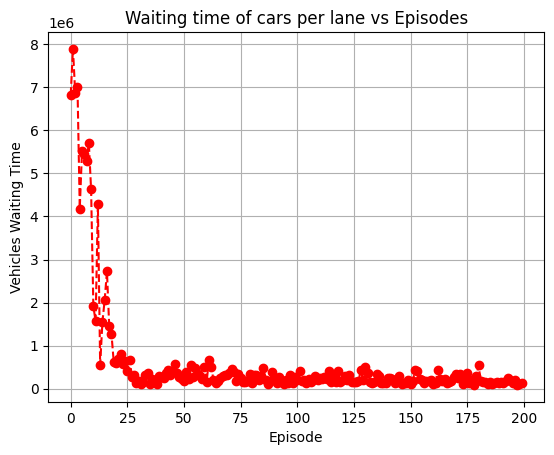

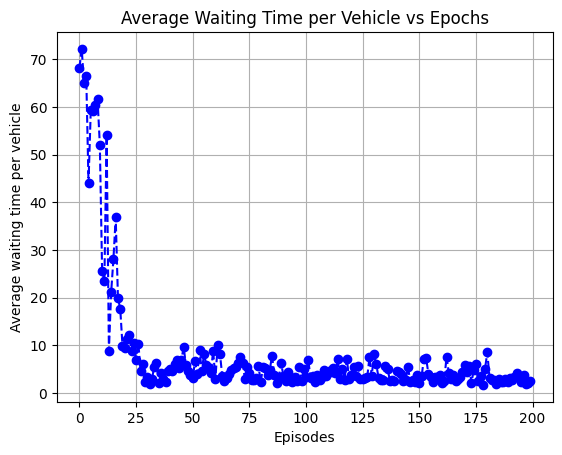

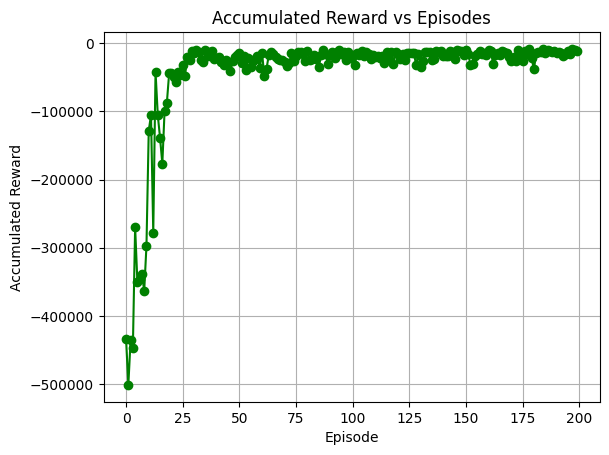

In [8]:
# this is the main entry point of this script
if __name__ == "__main__":
    # Assign the model name, training flag, number of epochs, and number of steps
    model_name = 'model'
    training = True
    num_epochs = 200
    num_steps = 500
    
    # Run the simulation with the given parameters
    run_simulation(train=training, model_name=model_name, epochs=num_epochs, steps=num_steps)
    
    
    
    
    